Using device: cuda
Starting generation... Output: dataset_stft/
Processing /kaggle/input/eeg-data/subject_215_pre.csv -> Label: stressed


KeyboardInterrupt: 

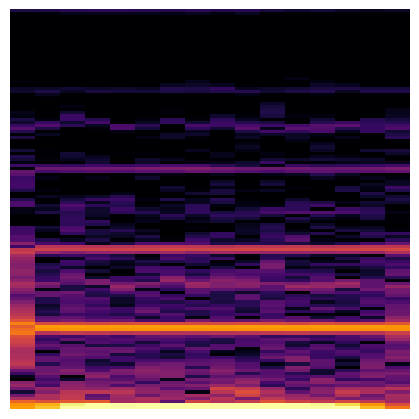

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

# --- 1. CONFIGURATION ---
fs = 500
window_sec = 4
overlap = 0.5
n_per_window = int(window_sec * fs)             # 2000 samples
step_size = int(n_per_window * (1 - overlap))   # 1000 samples step

# STFT Params
n_fft = 256
hop_length = n_fft // 2  # 128
win_length = n_fft

# Output Directory
output_base = "dataset_stft"
classes = {0: "not_stressed", 1: "stressed"}
for label_name in classes.values():
    os.makedirs(os.path.join(output_base, label_name), exist_ok=True)

# Labels
pre_labels = {
    215: 1, 216: 1, 217: 0, 218: 0, 219: 0, 220: 0
}

# --- 2. GPU SETUP ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

window_tensor = torch.hann_window(win_length).to(device)

def process_all_patients_safe_gpu_normalized():
    total_images = 0
    print(f"Starting generation... Output: {output_base}/")
    
    for subject_id, label in pre_labels.items():
        filename = f"/kaggle/input/eeg-data/subject_{subject_id}_pre.csv"
        
        if not os.path.exists(filename):
            print(f"[WARNING] File not found: {filename}. Skipping.")
            continue
            
        label_str = classes[label]
        print(f"Processing {filename} -> Label: {label_str}")
        
        try:
            df = pd.read_csv(filename)
            eeg_data = df.iloc[:, 1:32]
            
            for col_name in eeg_data.columns:
                signal = eeg_data[col_name].values
                signal = signal - np.mean(signal)
                
                window_count = 0
                for start_idx in range(0, len(signal) - n_per_window + 1, step_size):
                    end_idx = start_idx + n_per_window
                    chunk = signal[start_idx:end_idx]
                    
                    # --- GPU CALCULATION ---
                    chunk_tensor = torch.tensor(chunk, dtype=torch.float32).to(device)
                    
                    stft_out = torch.stft(
                        chunk_tensor, 
                        n_fft=n_fft, 
                        hop_length=hop_length, 
                        win_length=win_length,
                        window=window_tensor,
                        center=True,
                        return_complex=True
                    )
                    
                    magnitude = torch.abs(stft_out)
                    
                    # --- THE FIX: NORMALIZE TO MATCH SCIPY ---
                    # We divide by (Window Length / 2) to normalize the amplitude
                    magnitude = magnitude / (win_length / 2)
                    
                    magnitude_db = 20 * torch.log10(magnitude + 1e-10)
                    img_data = magnitude_db.cpu().numpy()
                    
                    # --- PLOTTING ---
                    fig = plt.figure(figsize=(4, 4))
                    ax = plt.Axes(fig, [0., 0., 1., 1.])
                    ax.set_axis_off()
                    fig.add_axes(ax)
                    
                    ax.imshow(img_data, aspect='auto', origin='lower', cmap='inferno', vmin=-20, vmax=40)
                    
                    save_name = f"{subject_id}_pre_{col_name}_{window_count:04d}.png"
                    save_path = os.path.join(output_base, label_str, save_name)
                    
                    plt.savefig(save_path)
                    plt.close(fig)
                    
                    window_count += 1
                    total_images += 1
            
        except Exception as e:
            print(f"[ERROR] Failed on {filename}: {e}")

    print(f"\nProcessing Complete! Total Images Generated: {total_images}")

if __name__ == "__main__":
    process_all_patients_safe_gpu_normalized()

labels = { 
201: {"pre": 1, "post": 0},
202: {"pre": 0, "post": 0},
203: {"pre": 1, "post": 0},
204: {"pre": 0, "post": 0},
205: {"pre": 1, "post": 0},
206: {"pre": 0, "post": 0},
207: {"pre": 1, "post": 1},
208: {"pre": 0, "post": 0},
209: {"pre": 1, "post": 0},
211: {"pre": 1, "post": 0},
212: {"pre": 1, "post": 0},
213: {"pre": 0, "post": 0},
214: {"pre": 0, "post": 0},
215: {"pre": 1, "post": 0},
216: {"pre": 1, "post": 0},
217: {"pre": 0, "post": 0},
218: {"pre": 0, "post": 0},
219: {"pre": 0, "post": 0},
220: {"pre": 0, "post": 0},
}

In [4]:
import os
import glob

# Defines
output_base = "/kaggle/working/dataset_stft"
classes = ["stressed", "not_stressed"]
subject_ids = [
    201, 202, 203, 204, 205, 206, 207, 208, 209, 
    211, 212, 213, 214, 215, 216, 217, 218, 219, 220
]

print("Checking image counts per patient...")
print(f"{'Subject ID':<12} | {'Count':<10} | {'Status'}")
print("-" * 35)

for sub_id in subject_ids:
    # Search for files starting with this ID in both folders
    pattern = f"{sub_id}_pre_*.png"
    
    count = 0
    for label in classes:
        folder_path = os.path.join(output_base, label)
        # Use glob to count files matching the pattern
        files = glob.glob(os.path.join(folder_path, pattern))
        count += len(files)
        
    status = "✅ OK" if count > 2500 else "❌ MISSING"
    print(f"{sub_id:<12} | {count:<10} | {status}")

Checking image counts per patient...
Subject ID   | Count      | Status
-----------------------------------
201          | 2790       | ✅ OK
202          | 2945       | ✅ OK
203          | 2759       | ✅ OK
204          | 2945       | ✅ OK
205          | 1860       | ❌ MISSING
206          | 1860       | ❌ MISSING
207          | 1829       | ❌ MISSING
208          | 1860       | ❌ MISSING
209          | 1860       | ❌ MISSING
211          | 1860       | ❌ MISSING
212          | 1829       | ❌ MISSING
213          | 1829       | ❌ MISSING
214          | 1860       | ❌ MISSING
215          | 1860       | ❌ MISSING
216          | 1829       | ❌ MISSING
217          | 1829       | ❌ MISSING
218          | 1829       | ❌ MISSING
219          | 1829       | ❌ MISSING
220          | 1829       | ❌ MISSING


In [5]:
import shutil
import os
from IPython.display import FileLink

# --- 1. CONFIGURATION ---
folder_to_zip = "dataset_stft"  # The folder you created
output_filename = "dataset_stft" # The name of the zip file

# --- 2. ZIP THE FOLDER ---
print(f"Zipping '{folder_to_zip}'... This may take a few minutes (50k+ files).")

# This creates 'dataset_stft_v3.zip' in your working directory
shutil.make_archive(output_filename, 'zip', folder_to_zip)

print(f"Success! Created {output_filename}.zip")

# --- 3. GENERATE DOWNLOAD LINK ---
# Click the link below to download immediately
FileLink(f'{output_filename}.zip')

Zipping 'dataset_stft'... This may take a few minutes (50k+ files).
Success! Created dataset_stft.zip


/kaggle/working/dataset_stft.zip

CNN - model

In [5]:
import os
import shutil
import random

# Source Directory (Where your 35k images are)
source_dir = "/kaggle/input/dataset-stft-filter"
train_dir = "dataset_final/train"
val_dir = "dataset_final/val"

# --- 1. DEFINE THE SPLIT MANUALLY ---
# We pick 4 validation subjects (2 Stressed, 2 Not Stressed) to ensure balance.
val_subjects = [215, 216, 218, 220]  
# 215, 216 = Stressed (1)
# 218, 220 = Not Stressed (0)

# The rest go to training
all_subjects = [
    201, 202, 203, 204, 205, 206, 207, 208, 209, 
    211, 212, 213, 214, 215, 216, 217, 218, 219, 220
]
train_subjects = [s for s in all_subjects if s not in val_subjects]

print(f"Training Subjects: {len(train_subjects)}")
print(f"Validation Subjects: {len(val_subjects)}")

# --- 2. MOVE THE FILES ---
classes = ["stressed", "not_stressed"]

for label in classes:
    # Create dirs
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    
    # List all images in the source folder
    src_folder = os.path.join(source_dir, label)
    images = os.listdir(src_folder)
    
    for img in images:
        # Check the filename to see which patient it belongs to
        # Filename format: "201_pre_Fp1_0000.png"
        subject_id = int(img.split('_')[0])
        
        src_path = os.path.join(src_folder, img)
        
        if subject_id in val_subjects:
            dst_path = os.path.join(val_dir, label, img)
        else:
            dst_path = os.path.join(train_dir, label, img)
            
        shutil.copy(src_path, dst_path)

print("Dataset Split Complete!")

Training Subjects: 15
Validation Subjects: 4
Dataset Split Complete!


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# --- 1. CONFIGURATION ---
BATCH_SIZE = 32
# Start with a slightly higher LR, let the Scheduler lower it later
LEARNING_RATE = 0.0001  
EPOCHS = 40             
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAIN_DIR = "/kaggle/working/dataset_final/train"
VAL_DIR = "/kaggle/working/dataset_final/val"

print(f"🚀 Golden Training on: {DEVICE}")

# --- 2. DATA (Same Heavy Augmentation) ---
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. 5-LAYER MODEL (Same as before) ---
class BrainStressCNN5Layer(nn.Module):
    def __init__(self):
        super(BrainStressCNN5Layer, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.dropout = nn.Dropout(0.5) 
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = BrainStressCNN5Layer().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# --- NEW: SCHEDULER ---
# If Val Acc doesn't improve for 3 epochs, cut LR by 10x
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

# --- 4. TRAINING LOOP WITH CHECKPOINTING ---
print("\n🔥 Starting Training with Checkpointing...")
best_val_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    
    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_total
    
    # Update Scheduler
    scheduler.step(val_acc)
    
    # MANUAL PRINT: Check current Learning Rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"   -> Current Learning Rate: {current_lr}")
    
    # --- CRITICAL: SAVE ONLY IF IMPROVED ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_stress_model.pth")
        print(f"Epoch {epoch+1} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}% --> 💾 Saved Best Model!")
    else:
        print(f"Epoch {epoch+1} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}%")

print(f"\n🏆 Done! Best Validation Accuracy was: {best_val_acc:.2f}%")
print("Load 'best_stress_model.pth' for your final predictions.")

🚀 Golden Training on: cuda

🔥 Starting Training with Checkpointing...
   -> Current Learning Rate: 0.0001
Epoch 1 | Train: 60.62% | Val: 43.81% --> 💾 Saved Best Model!
   -> Current Learning Rate: 0.0001
Epoch 2 | Train: 68.07% | Val: 51.30% --> 💾 Saved Best Model!
   -> Current Learning Rate: 0.0001
Epoch 3 | Train: 69.98% | Val: 47.60%
   -> Current Learning Rate: 0.0001
Epoch 4 | Train: 70.65% | Val: 43.60%
   -> Current Learning Rate: 0.0001
Epoch 5 | Train: 71.65% | Val: 43.92%
   -> Current Learning Rate: 1e-05
Epoch 6 | Train: 72.71% | Val: 44.93%
   -> Current Learning Rate: 1e-05
Epoch 7 | Train: 73.98% | Val: 43.21%
   -> Current Learning Rate: 1e-05
Epoch 8 | Train: 74.18% | Val: 44.29%
   -> Current Learning Rate: 1e-05
Epoch 9 | Train: 74.62% | Val: 43.19%


KeyboardInterrupt: 

🚀 5-Layer Robust Training on: cuda

🔥 Starting Training...

Epoch 1/30 | Train Acc: 67.69% | Val Acc: 46.51%

Epoch 2/30 | Train Acc: 75.60% | Val Acc: 49.00%

Epoch 3/30 | Train Acc: 78.60% | Val Acc: 60.83%

Epoch 4/30 | Train Acc: 80.22% | Val Acc: 53.82%

Epoch 5/30 | Train Acc: 81.22% | Val Acc: 60.20%

Epoch 6/30 | Train Acc: 82.38% | Val Acc: 51.42%

Epoch 7/30 | Train Acc: 83.49% | Val Acc: 50.99%

Epoch 8/30 | Train Acc: 84.38% | Val Acc: 50.32%

Epoch 9/30 | Train Acc: 85.39% | Val Acc: 65.37%

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os

# --- 1. CONFIGURATION ---
BATCH_SIZE = 32
LEARNING_RATE = 0.0001  # Transformers need a much lower LR!
EPOCHS = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAIN_DIR = "/kaggle/working/dataset_final/train"
VAL_DIR = "/kaggle/working/dataset_final/val"

print(f"🚀 Training Vision Transformer (ViT) on: {DEVICE}")

# --- 2. DATA LOADERS ---
# ViT expects 224x224.
# We keep augmentation light because ViTs are sensitive.
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. LOAD PRE-TRAINED VIT ---
print("🧠 Loading ViT-Base-16 (ImageNet Weights)...")

# Load the model with default weights
weights = models.ViT_B_16_Weights.DEFAULT
model = models.vit_b_16(weights=weights)

# --- 4. MODIFY THE HEAD ---
# ViT has a 'heads' block. The classifier is inside.
# We freeze the backbone first to stabilize training (Optional, but recommended for ViT)
for param in model.parameters():
    param.requires_grad = False 

# Unfreeze the last block and the head so they can learn
for param in model.encoder.layers.encoder_layer_11.parameters():
    param.requires_grad = True

# Replace the head
num_features = model.heads.head.in_features
model.heads.head = nn.Linear(num_features, 2) # 2 Classes

model = model.to(DEVICE)

# --- 5. OPTIMIZER ---
criterion = nn.CrossEntropyLoss()
# ViT is very sensitive. Use a small LR and Weight Decay.
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

# --- 6. TRAINING LOOP ---
print("\n🔥 Starting ViT Training...")
best_val_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    
    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_total
    
    scheduler.step(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_stress_vit.pth")
        print(f"Epoch {epoch+1} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}% --> 💾 Saved Best!")
    else:
        print(f"Epoch {epoch+1} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}%")

print(f"\n🏆 Best ViT Accuracy: {best_val_acc:.2f}%")

🚀 Training Vision Transformer (ViT) on: cuda
🧠 Loading ViT-Base-16 (ImageNet Weights)...
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 177MB/s]  



🔥 Starting ViT Training...
Epoch 1 | Train: 71.47% | Val: 42.43% --> 💾 Saved Best!
Epoch 2 | Train: 79.12% | Val: 46.94% --> 💾 Saved Best!
Epoch 3 | Train: 81.80% | Val: 49.07% --> 💾 Saved Best!
Epoch 4 | Train: 84.10% | Val: 51.46% --> 💾 Saved Best!
Epoch 5 | Train: 86.28% | Val: 50.99%
Epoch 6 | Train: 87.54% | Val: 48.37%
Epoch 7 | Train: 89.12% | Val: 49.52%
Epoch 8 | Train: 92.24% | Val: 50.93%
Epoch 9 | Train: 92.87% | Val: 49.35%
Epoch 10 | Train: 93.11% | Val: 48.37%
Epoch 11 | Train: 93.62% | Val: 49.12%


KeyboardInterrupt: 

.

.

.


.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import copy

# --- 1. CONFIGURATION ---
BATCH_SIZE = 32
LEARNING_RATE = 0.0005  # EfficientNet prefers lower LR
EPOCHS = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAIN_DIR = "/kaggle/working/dataset_final/train" # Your new filtered data
VAL_DIR = "/kaggle/working/dataset_final/val"

print(f"🚀 Training EfficientNet-B0 on: {DEVICE}")

# --- 2. DATA LOADERS ---
# EfficientNet expects 224x224 RGB images
# ImageFolder automatically converts your Grayscale to RGB (3 channels)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

🚀 Training EfficientNet-B0 on: cuda


In [13]:
# --- 3. MODEL: EFFICIENTNET-B0 ---
print("🧠 Loading Pre-trained EfficientNet...")
# Download weights trained on ImageNet (14M images)
weights = models.EfficientNet_B0_Weights.DEFAULT
model = models.efficientnet_b0(weights=weights)

# Freeze the early layers (Optional: keeps the basic feature detectors stable)
# for param in model.features.parameters():
#     param.requires_grad = False

# Modify the Classifier Head
# EfficientNet's classifier is a Sequential block. We replace the last Linear layer.
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_features, 2) # 2 Classes: Stressed vs Not
)

model = model.to(DEVICE)

# --- 4. OPTIMIZER ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3)

🧠 Loading Pre-trained EfficientNet...


In [14]:
# --- 5. TRAINING LOOP ---
print("\n🔥 Starting EfficientNet Training...")
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)
    
    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_total
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    scheduler.step(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_efficientnet_stress.pth")
        print("   --> 💾 Saved Best Model!")

print(f"\n🏆 Best EfficientNet Accuracy: {best_val_acc:.2f}%")


🔥 Starting EfficientNet Training...
Epoch 1/30 | Train Acc: 67.45% | Val Acc: 43.32% | LR: 0.000500
   --> 💾 Saved Best Model!
Epoch 2/30 | Train Acc: 73.81% | Val Acc: 46.60% | LR: 0.000500
   --> 💾 Saved Best Model!
Epoch 3/30 | Train Acc: 75.88% | Val Acc: 44.41% | LR: 0.000500
Epoch 4/30 | Train Acc: 77.31% | Val Acc: 47.38% | LR: 0.000500
   --> 💾 Saved Best Model!
Epoch 5/30 | Train Acc: 77.85% | Val Acc: 40.22% | LR: 0.000500
Epoch 6/30 | Train Acc: 79.23% | Val Acc: 39.80% | LR: 0.000500
Epoch 7/30 | Train Acc: 79.77% | Val Acc: 40.82% | LR: 0.000500


KeyboardInterrupt: 

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# --- 1. CONFIGURATION ---
BATCH_SIZE = 32
LEARNING_RATE = 0.0003  # LSTMs need gentle learning rates
EPOCHS = 40
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAIN_DIR = "/kaggle/working/dataset_final/train"
VAL_DIR = "/kaggle/working/dataset_final/val"

print(f"🚀 Training CRNN (Hybrid) on: {DEVICE}")

# --- 2. DATA LOADERS ---
# CRNNs are sensitive to rotation/flipping because Time flows one way!
# So we REMOVE RandomHorizontalFlip.
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.05)), # Shift is okay
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


🚀 Training CRNN (Hybrid) on: cuda


In [16]:

# --- 3. THE CRNN MODEL ---
class EEG_CRNN(nn.Module):
    def __init__(self):
        super(EEG_CRNN, self).__init__()
        
        # --- PART 1: CNN (Feature Extractor) ---
        # We want to crush the Height (Freq) but keep some Width (Time)
        
        # Input: (3, 224, 224)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # -> (64, 112, 112)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # -> (128, 56, 56)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)) # Pool Height only! Keep Time resolution.
            # -> (256, 28, 56)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)) # Pool Height only!
            # -> (512, 14, 56)
        )
        
        # After Conv4, we have:
        # Channels: 512
        # Height (Freq features): 14
        # Width (Time steps): 56
        
        # We collapse Height into Channels
        self.cnn_output_size = 512 * 14 
        
        # --- PART 2: LSTM (Sequence Modeler) ---
        self.lstm = nn.LSTM(
            input_size=self.cnn_output_size, 
            hidden_size=256, 
            num_layers=2, 
            batch_first=True,
            dropout=0.5,
            bidirectional=True # Look forward and backward in time
        )
        
        # --- PART 3: CLASSIFIER ---
        # Bidirectional = 2 * hidden_size
        self.fc = nn.Sequential(
            nn.Linear(256 * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        # 1. Run CNN
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Shape: (Batch, 512, 14, 56)
        b, c, h, w = x.size()
        
        # 2. Reshape for LSTM
        # We want: (Batch, Time, Features)
        # Permute to: (Batch, Width, Channels, Height) -> (Batch, 56, 512, 14)
        x = x.permute(0, 3, 1, 2) 
        
        # Flatten Channels and Height: (Batch, 56, 512*14)
        x = x.reshape(b, w, -1)
        
        # 3. Run LSTM
        # out: (Batch, Time, Hidden*2)
        # _ : (hidden state, cell state) - we ignore these
        lstm_out, _ = self.lstm(x)
        
        # 4. Classification
        # We take the output of the LAST time step
        # Shape: (Batch, Hidden*2)
        last_time_step = lstm_out[:, -1, :]
        
        output = self.fc(last_time_step)
        return output

model = EEG_CRNN().to(DEVICE)

# --- 4. TRAINING SETUP ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# --- 5. TRAINING LOOP ---
print("\n🔥 Starting CRNN Training...")
best_val_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    
    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_total
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_stress_crnn.pth")
        print("   --> 💾 Saved Best Model!")

print(f"\n🏆 Best CRNN Accuracy: {best_val_acc:.2f}%")


🔥 Starting CRNN Training...
Epoch 1/40 | Train Acc: 55.82% | Val Acc: 41.16%
   --> 💾 Saved Best Model!
Epoch 2/40 | Train Acc: 60.49% | Val Acc: 48.58%
   --> 💾 Saved Best Model!
Epoch 3/40 | Train Acc: 62.74% | Val Acc: 45.87%
Epoch 4/40 | Train Acc: 64.66% | Val Acc: 50.50%
   --> 💾 Saved Best Model!
Epoch 5/40 | Train Acc: 66.12% | Val Acc: 48.14%
Epoch 6/40 | Train Acc: 68.16% | Val Acc: 37.65%
Epoch 7/40 | Train Acc: 68.80% | Val Acc: 47.08%


KeyboardInterrupt: 

In [1]:
print(1)

1
